<a href="https://colab.research.google.com/github/Elizaluckianchikova/Algorithms-and-data-structure/blob/main/MLHW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Непараметрическая регрессия
**Непараметрическая регрессия** - это метод моделирования зависимости между переменными без явного задания функциональной формы отношения. В отличие от параметрической регрессии, в непараметрической регрессии не предполагается, что отношение между переменными можно описать конкретной математической функцией с заранее заданными параметрами.

Вместо этого непараметрическая регрессия позволяет моделировать зависимость между переменными, используя данные для определения формы этой зависимости. Она может быть особенно полезной в случаях, когда форма зависимости сложна и не может быть учтена с помощью простой аналитической функции.

Некоторые из методов, которые могут использоваться для непараметрической регрессии, включают метод ближайших соседей (k-NN), ядерную регрессию, сглаживание сплайнами и другие методы, которые не предполагают явной функциональной зависимости между переменными.

Непараметрическая регрессия может быть полезным инструментом для моделирования сложных зависимостей в данных, когда нет явной функциональной формы, которая описывает отношение между переменными.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# from scipy.io.arff import loadarff
##- данная строка закомментирована, что означает, что она не будет выполнена. Это может быть использовано для временного исключения определенной строки кода из исполнения, если она в данный момент не нужна.
##Этот код позволяет вам использовать функции и возможности указанных библиотек в вашем проекте.

In [25]:
# raw_data = loadarff('/content/dataset_191_wine.arff')
# data = pd.DataFrame(raw_data[0])
# data['class'] = data['class'].str.decode("utf-8")

# raw_data1 = loadarff('/content/briges.arff')
# data1 = pd.DataFrame(raw_data1[0])


In [3]:
from sklearn.datasets import fetch_openml
data_raw = fetch_openml(data_id = 187, as_frame = True)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [4]:
X = data_raw.data.rename(columns = {'OD280%2FOD315_of_diluted_wines':'OD280_OD315_of_diluted_wines'})
y = data_raw.target

В данном фрагменте кода вы создаете переменные X и y из данных, загруженных с помощью функции fetchopenml из библиотеки scikit-learn.

1. `X = dataraw.data.rename(columns = {'OD280%2FOD315ofdilutedwines':'OD280OD315ofdilutedwines'})` - здесь вы создаете переменную X, которая содержит признаки (features) из загруженных данных. Вы используете метод rename для переименования столбца 'OD280%2FOD315ofdilutedwines' в 'OD280OD315ofdilutedwines' и сохранения этой операции в переменной X.

2. y = data_raw.target - здесь вы создаете переменную y, которая содержит целевую переменную (target) из загруженных данных.

Таким образом, вы подготавливаете данные для дальнейшего использования в моделировании, где переменная X содержит признаки, а переменная y содержит целевую переменную, которую вы хотите предсказать или моделировать.


In [5]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import DistanceMetric


class NonParamRegrClassifier(BaseEstimator, ClassifierMixin):
    kernel_funcs = {'uniform':      lambda x: 0.5 * (abs(x) <= 1),
                    'triangular':   lambda x: (1 - abs(x)) * (abs(x) <= 1),
                    'epanechnikov': lambda x: (0.75 * (1 - x**2)) * (abs(x) <= 1),
                    'quartic':      lambda x: (0.9375 * (1 - x**2)**2) * (abs(x) <= 1)
                    }

    def __init__(self, kernel = 'epanechnikov', metric = 'euclidean',
                 kernel_window = ['k_neighbours', 1]):
        self.kernel = kernel
        self.metric = metric
        self.kernel_window = kernel_window

    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        # Store the classes seen during fit
        self.classes = np.unique(y)
        self.X_train = X
        self.y_train = y
        # Return the classifier
        return self

    def kernel_weight(self, dists):
        kfunc = self.kernel_funcs[self.kernel]
        if self.kernel_window[0] == 'fixed':
            R = dists.max()
            h = R * self.kernel_window[1]
            return kfunc(dists/h)

        if self.kernel_window[0] == 'k_neighbours':
            k = self.kernel_window[1]
            dist_k_1 = np.sort(dists, axis=1)[:, [k]]
            return kfunc(dists/dist_k_1)


    def predict(self, X):
        # # Check if fit has been called
        # check_is_fitted(self)
        # Input validation
        X = check_array(X)

        y_train_1h = pd.get_dummies(self.y_train).to_numpy()

        dists = DistanceMetric.get_metric(self.metric).pairwise(X, self.X_train)

        kernel_weights = self.kernel_weight(dists)

        reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
        y_pred = self.classes[reg_y_pred.argmax(axis=1)]
        self.reg_y_pred = reg_y_pred

        return y_pred

 Определение класса NonParamRegrClassifier, который наследует базовые классы BaseEstimator и ClassifierMixin.
3. В классе NonParamRegrClassifier определяются методы __init__, fit и predict, которые реализуют инициализацию классификатора, обучение модели и предсказание меток классов соответственно.
4. Внутри метода fit происходит проверка и сохранение обучающих данных.
5. Метод kernel_weight вычисляет веса для непараметрической регрессии на основе выбранного ядерного метода.
6. Метод predict использует полученные веса и обучающие данные для предсказания меток классов для новых данных.

Этот код реализует пользовательский классификатор на основе непараметрической регрессии, который может быть использован для классификации данных.


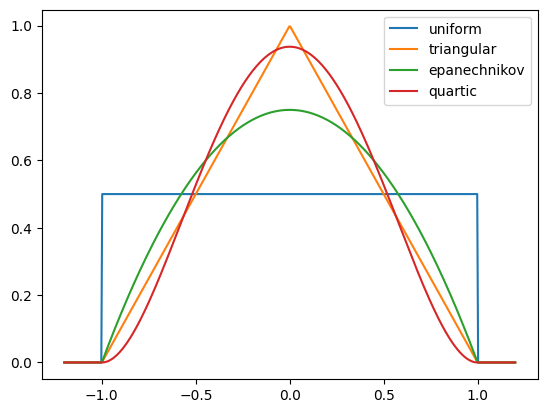

In [6]:
for fname in NonParamRegrClassifier.kernel_funcs:
    a = np.linspace(-1.2, 1.2, 500)
    b = NonParamRegrClassifier.kernel_funcs[fname](a)
    plt.plot(a, b, label = fname)
plt.legend()
#визуализация_функции_ядра


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(),
                     NonParamRegrClassifier(kernel='uniform', metric='manhattan',
                               kernel_window = ['fixed', 0.5]))
#создаю_ конвейер_для_предказания_ и_обучения_модели

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=9)
#разделение данных на обучающий и тестовый наборы

In [9]:
pipe.fit(X_train, y_train)
#обучаю конвейер, который включает в себя масштабирование данных и ваш пользовательский классификатор, на обучающих данных X_train и y_train.

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('nonparamregrclassifier',
                 NonParamRegrClassifier(kernel='uniform',
                                        kernel_window=['fixed', 0.5],
                                        metric='manhattan'))])

In [10]:
y_pred = pipe.predict(X_test)
#использую обученный конвейер для предсказания меток классов на тестовых данных X_test.

In [11]:
from sklearn.metrics import f1_score, accuracy_score
(accuracy_score(y_test, y_pred),
f1_score(y_test, y_pred, average='macro'),
f1_score(y_test, y_pred, average='micro'),
f1_score(y_test, y_pred, average='weighted'))

(0.8611111111111112,
 0.8716049382716049,
 0.8611111111111112,
 0.8656378600823046)

In [12]:
pipe = make_pipeline(StandardScaler(),
                     NonParamRegrClassifier())
n = y.size
grid = {'nonparamregrclassifier__kernel': list(NonParamRegrClassifier.kernel_funcs.keys()),
        'nonparamregrclassifier__metric': ['euclidean','manhattan','chebyshev'],
        'nonparamregrclassifier__kernel_window':
         [['k_neighbours', i] for i in range(1, round(n ** 0.5) + 1)] +
         [['fixed', i] for i in (np.arange(1/(n**0.5), 1, 1/(n**0.5)).tolist() + [1])]
        }

Код в
ключает в себя вычисление различных метрик качества (accuracy и F1 score) для классификации с помощью sklearn.metrics и начало определения параметров для поиска по сетке (Grid Search) с использованием Pipeline в библиотеке scikit-learn.

Здесь у вас есть следующие шаги:

1. Вычисление метрик accuracyscore и f1score для оценки качества модели классификации на тестовом наборе данных ytest и предсказанных значениях ypred.
2. Создание Pipeline с применением StandardScaler и NonParamRegrClassifier (предположительно, некого регрессора без параметров).
3. Вычисление n (размера y) для использования этой информации далее в параметрах сетки.
4. Определение сетки параметров для поиска по сетке (Grid Search) для NonParamRegrClassifier, включающей различные ядерные функции, метрики расстояния и виды окон различных размеров.

Этот код готовит параметры для Grid Search и предварительно вычисляет метрики качества для вашей модели классификации. Далее, вероятно, идет запуск GridSearchCV для подбора оптимальных параметров модели.

In [13]:
grid


{'nonparamregrclassifier__kernel': ['uniform',
  'triangular',
  'epanechnikov',
  'quartic'],
 'nonparamregrclassifier__metric': ['euclidean', 'manhattan', 'chebyshev'],
 'nonparamregrclassifier__kernel_window': [['k_neighbours', 1],
  ['k_neighbours', 2],
  ['k_neighbours', 3],
  ['k_neighbours', 4],
  ['k_neighbours', 5],
  ['k_neighbours', 6],
  ['k_neighbours', 7],
  ['k_neighbours', 8],
  ['k_neighbours', 9],
  ['k_neighbours', 10],
  ['k_neighbours', 11],
  ['k_neighbours', 12],
  ['k_neighbours', 13],
  ['fixed', 0.07495316889958614],
  ['fixed', 0.14990633779917228],
  ['fixed', 0.22485950669875843],
  ['fixed', 0.29981267559834457],
  ['fixed', 0.3747658444979307],
  ['fixed', 0.44971901339751685],
  ['fixed', 0.524672182297103],
  ['fixed', 0.5996253511966891],
  ['fixed', 0.6745785200962753],
  ['fixed', 0.7495316889958614],
  ['fixed', 0.8244848578954476],
  ['fixed', 0.8994380267950337],
  ['fixed', 0.9743911956946198],
  ['fixed', 1]]}

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import f1_score, make_scorer

gridsearch = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          cv= LeaveOneOut(),
                          scoring='f1_macro')

# now perform full fit on whole pipeline
gridsearch.fit(X, y)
#оптимизация гиперпараметров вашей модели, используя Grid Search с кросс-валидацией Leave-One-Out и метрикой f1_macro как метрикой оценки.


Выходные данные были обрезаны до нескольких последних строк (5000).
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: invalid value encountered in divide
  reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: invalid value encountered in divide
  reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: invalid value encountered in divide
  reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: invalid value encountered in divide
  reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: invalid value encountered in divide
  reg_y_pred = kernel_weights @ y_train_1h / kernel_weights.sum(axis=1, keepdims = True)
<ipython-input-5-cacff2d6752e>:57: RuntimeWarning: i

GridSearchCV(cv=LeaveOneOut(),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('nonparamregrclassifier',
                                        NonParamRegrClassifier())]),
             param_grid={'nonparamregrclassifier__kernel': ['uniform',
                                                            'triangular',
                                                            'epanechnikov',
                                                            'quartic'],
                         'nonparamregrclassifier__kernel_window': [['k_neighbours',
                                                                    1],
                                                                   ['k_neighbours',
                                                                    2],
                                                                   ['k_neighbours',
                                                                    3],
                                                                   ['k_neighbo...
                                                                    0.3747658444979307],
                                                                   ['fixed',
                                                                    0.44971901339751685],
                                                                   ['fixed',
                                                                    0.524672182297103],
                                                                   ['fixed',
                                                                    0.5996253511966891],
                                                                   ['fixed',
                                                                    0.6745785200962753],
                                                                   ['fixed',
                                                                    0.7495316889958614],
                                                                   ['fixed',
                                                                    0.8244848578954476],
                                                                   ['fixed',
                                                                    0.8994380267950337],
                                                                   ['fixed',
                                                                    0.9743911956946198],
                                                                   ['fixed',
                                                                    1]],
                         'nonparamregrclassifier__metric': ['euclidean',
                                                            'manhattan',
                                                            'chebyshev']},
             scoring='f1_macro')

In [15]:
print("Best parameters from gridsearch: {}".format(gridsearch.best_params_))
print("CV score=%0.3f" % gridsearch.best_score_)
cv_results = pd.DataFrame(gridsearch.cv_results_)
# print(cv_results)

# Best parameters from gridsearch: {'nonparamregrclassifier__kernel': 'uniform',
# 'nonparamregrclassifier__kernel_window': ['k_neighbours', 10], 'nonparamregrclassifier__metric': 'manhattan'}
#CV score=0.989

Best parameters from gridsearch: {'nonparamregrclassifier__kernel': 'uniform', 'nonparamregrclassifier__kernel_window': ['k_neighbours', 10], 'nonparamregrclassifier__metric': 'manhattan'}
CV score=0.989


После выполнения этого кода вы увидите лучшие найденные параметры для вашей модели (ядро, окно ядра, метрика) и оценку качества модели (CV score). Также результаты сетки параметров и их соответствующие значения метрик и других параметров будут доступны в DataFrame cv_results, который можно изучить для получения более детальной информации о процессе оптимизации параметров и результатов кросс-валидации.

In [16]:
cv_results[['kernel_window_type', 'kernel_window_param']] = pd.DataFrame(
    cv_results['param_nonparamregrclassifier__kernel_window'].apply(pd.Series),
    index=cv_results.index
)

Этот код в целом преобразует информацию о параметрах окна ядра из одного столбца DataFrame в два отдельных столбца (kernel_window_type и kernel_window_param), что делает анализ и интерпретацию этих данных более простым и удобным.

**GridSearchCV** - это класс из библиотеки scikit-learn (sklearn), который позволяет выполнить поиск по сетке параметров (Grid Search) для тюнинга гиперпараметров модели. Этот класс позволяет определить сетку параметров, которые вы хотите протестировать, и автоматически выполнить обучение модели с каждой комбинацией параметров, используя кросс-валидацию для оценки и выбора лучшей комбинации.

GridSearchCV принимает несколько основных параметров:
- estimator: модель, для которой вы хотите подобрать гиперпараметры.
- param_grid: словарь параметров, определяющих параметры, которые должны быть протестированы.
- scoring: метрика, по которой осуществляется оценка модели.
- cv: стратегия кросс-валидации.
- n_jobs: количество параллельных работ для обучения модели.

После запуска GridSearchCV в выходных параметрах будет содержаться информация о лучших параметрах, найденных в результате поиска по сетке, а также результаты кросс-валидации для этих параметров. GridSearchCV — это мощный инструмент для оптимизации гиперпараметров модели и улучшения ее производительности.

In [17]:
df = cv_results.query("param_nonparamregrclassifier__kernel == 'uniform' and \
                  param_nonparamregrclassifier__metric == 'manhattan' and \
                  kernel_window_type == 'k_neighbours'")

# df = cv_results.query("param_nonparamregrclassifier__kernel == 'uniform' and \
#                   param_nonparamregrclassifier__metric == 'manhattan' and \
#                   kernel_window_type == 'fixed'")

Text(0, 0.5, 'Average CV F1 macro')

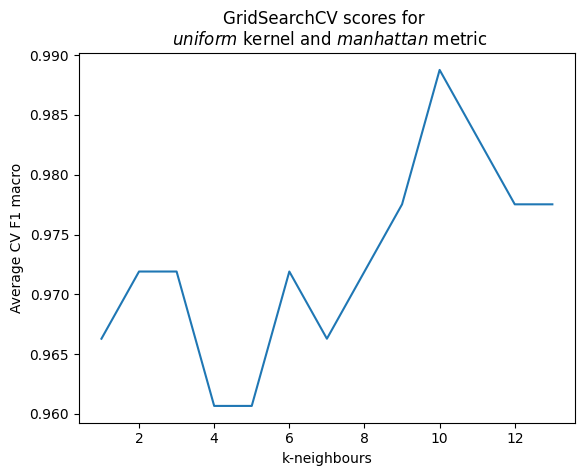

In [18]:
sns.lineplot(data=df, x='kernel_window_param', y = 'mean_test_score')
plt.title('GridSearchCV scores for \n $uniform$ kernel and $manhattan$ metric')
plt.xlabel('k-neighbours')
plt.ylabel('Average CV F1 macro')

 Код строит линейный график, описывающий, как изменяется среднее значение тестовой оценки в зависимости от параметра окна ядра, при использовании ядра 'uniform' и метрики 'manhattan'. Заголовок графика и подписи осей предоставляют контекст для лучшего понимания того, что отображается на графике.

In [ ]:
# Вывод результатов
print("Лучшие гиперпараметры:", best_params)
print("Лучшая F-мера:", best_score)
